In [ ]:
# Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# Google Authentication
auth.authenticate_user()

# Required libraries for data preprocessing
import re
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt

# MIMIC-III Data Extraction

The main references for MIMIC-III data extractions are as follows:
* https://mimic.mit.edu/iii/gettingstarted/
* https://mimic.mit.edu/iii/gettingstarted/cloud/bigquery/
* https://mimic.mit.edu/iii/mimictables
* https://github.com/YerevaNN/mimic3-benchmarks/
* https://github.com/ckbjimmy/gcp/blob/master/tutorial_py.ipynb




In [ ]:
# Project Configuration 
project_id='mimic-iii-extraction' # Refer to BigQuery project in Google Cloud Platform
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

## Querying the MIMIC-III Dataset

In [ ]:
# List all of available databases along with the table information
client = bigquery.Client(project='physionet-data')
datasets = client.list_datasets()
dataset_dicts = {}
for dataset in datasets:
  dataset_dicts[dataset.dataset_id] = [', '.join([table.table_id for table in client.list_tables(client.dataset(dataset.dataset_id))])]
dataset_df = pd.DataFrame.from_dict(dataset_dicts, orient='index').reset_index()
dataset_df.columns = ['Dataset', 'Tables']
dataset_df

,Dataset,Tables
0,eicu_crd_demo,"admissiondrug, admissiondx, allergy, apacheapsvar, apachepatientresult, apachepredvar, careplancareprovider, careplaneol, careplangeneral, careplangoal, careplaninfectiousdisease, customlab, diagnosis, hospital, infusiondrug, intakeoutput, lab, medication, microlab, note, nurseassessment, nursecare, nursecharting, pasthistory, patient, physicalexam, respiratorycare, respiratorycharting, treatment, vitalaperiodic, vitalperiodic"
1,mimic_core,"admissions, patients, transfers"
2,mimic_derived,"age, antibiotic, apsiii, bg, blood_differential, cardiac_marker, charlson, chemistry, coagulation, complete_blood_count, creatinine_baseline, crrt, dobutamine, dopamine, enzyme, epinephrine, first_day_bg, first_day_bg_art, first_day_gcs, first_day_height, first_day_lab, first_day_rrt, first_day_sofa, first_day_urine_output, first_day_vitalsign, first_day_weight, gcs, height, heparin, icp, icustay_detail, icustay_hourly, icustay_times, inflammation, invasive_line, kdigo_creatinine, kdigo_stages, kdigo_uo, lods, meld, neuroblock, norepinephrine, oasis, oxygen_delivery, phenylephrine, rhythm, rrt, sapsii, sepsis3, sirs, sofa, suspicion_of_infection, urine_output, urine_output_rate, vasopressin, ventilation, ventilator_setting, vitalsign, weight_durations"
3,mimic_hosp,"d_hcpcs, d_icd_diagnoses, d_icd_procedures, d_labitems, d_micro, diagnoses_icd, drgcodes, emar, emar_detail, hcpcsevents, labevents, microbiologyevents, pharmacy, poe, poe_detail, prescriptions, procedures_icd, services"
4,mimic_icu,"chartevents, d_items, datetimeevents, icustays, inputevents, outputevents, procedureevents"
5,mimiciii_clinical,"admissions, callout, caregivers, chartevents, cptevents, d_cpt, d_icd_diagnoses, d_icd_procedures, d_items, d_labitems, datetimeevents, diagnoses_icd, drgcodes, icustays, inputevents_cv, inputevents_mv, labevents, microbiologyevents, outputevents, patients, prescriptions, procedureevents_mv, procedures_icd, services, transfers"
6,mimiciii_demo,"admissions, callout, caregivers, chartevents, cptevents, d_cpt, d_icd_diagnoses, d_icd_procedures, d_items, d_labitems, datetimeevents, diagnoses_icd, drgcodes, icustays, inputevents_cv, inputevents_mv, labevents, microbiologyevents, outputevents, patients, prescriptions, procedureevents_mv, procedures_icd, services, transfers"
7,mimiciii_derived,"abx_micro_poe, abx_poe_list, abx_prescriptions_list, adenosine_durations, angus_sepsis, apsiii, blood_culture_icu_admit, blood_gas_first_day, blood_gas_first_day_arterial, bloodgasfirstday, bloodgasfirstdayarterial, ccs_dx, ccs_dx_raw, ccs_multi_dx, code_status, crrt_durations, crrtdurations, dobutamine_dose, dobutamine_durations, dopamine_dose, dopamine_durations, dopaminedurations, echo_data, echodata_structured, elixhauser_ahrq_v37, elixhauser_ahrq_v37_no_drg, elixhauser_quan, elixhauser_quan_score, epinephrine_dose, epinephrine_durations, epinephrinedurations, explicit, explicit_sepsis, fluid_balance, fluid_balance_staging, fluid_map, gcs_first_day, gcsfirstday, heightfirstday, heightweight, icustay_detail, icustay_hours, icustay_times, isuprel_durations, kdigo_creat, kdigo_creatinine, kdigo_stages, kdigo_stages_48hr, kdigo_stages_7day, kdigo_uo, labs_first_day, labsfirstday, lods, martin_sepsis, meld, meld_copy, milrinone_dose, milrinone_durations, milrinonedurations, mlods, norepinephrine_dose, norepinephrine_durations, norepinephrinedurations, noteevents_metadata, oasis, phenylephrine_dose, phenylephrine_durations, phenylephrinedurations, pivoted_bg, pivoted_bg_art, pivoted_fio2, pivoted_gcs, pivoted_height, pivoted_icp, pivoted_invasive_lines, pivoted_lab, pivoted_rrt, pivoted_sofa, pivoted_vital, qsofa, rrt, rrt_first_day, rrtfirstday, saps, sapsii, sepsis_cdc_surveillance, sepsis_nqf_0500, sirs, sofa, suspicion_of_infection, suspinfect_poe, uofirstday, urine_output, urine_output_first_day, urineoutput, vasopressin_dose, vasopressin_durations, vasopressindurations, vasopressordurations, ventdurations, ventfirstday


These are the main tables to extracts the records within
1. patients (Patients)
2. admissions (Admissions)
3. icustays (ICU Stays)
4. chartevents (Chart Events)

For more information, please kindly refer to :
https://mimic.mit.edu/iii/mimictables

In [ ]:
# We define several functions to make ease the extractions step
# Function to 
def to_str(items):
  return ','.join(items.astype('str'))

# Function to obtain the data from the cloud given the SQL query
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project_id, verbose=False, configuration={'query':{'useLegacySql': False}})


In [ ]:
# Sample
# Execute query : Obtain all available data and fields from ICU Stays table 
# ordered by their subject_id with the limit of 10 rows 
run_query('select * from `physionet-data.mimiciii_clinical.icustays` order by subject_id limit 10')

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,1,2,163353,243653,carevue,NICU,NICU,56,56,2138-07-17 21:20:07,2138-07-17 23:32:21,0.0918
1,2,3,145834,211552,carevue,MICU,MICU,12,12,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646
2,3,4,185777,294638,carevue,MICU,MICU,52,52,2191-03-16 00:29:31,2191-03-17 16:46:31,1.6785
3,4,5,178980,214757,carevue,NICU,NICU,56,56,2103-02-02 06:04:24,2103-02-02 08:06:00,0.0844
4,5,6,107064,228232,carevue,SICU,SICU,33,33,2175-05-30 21:30:54,2175-06-03 13:39:54,3.6729
5,7,7,118037,236754,carevue,NICU,NICU,56,56,2121-05-25 03:26:01,2121-05-25 21:10:19,0.7391
6,6,7,118037,278444,carevue,NICU,NICU,56,56,2121-05-23 15:35:29,2121-05-23 22:01:00,0.2677
7,8,8,159514,262299,carevue,NICU,NICU,56,56,2117-11-20 12:36:10,2117-11-21 14:24:55,1.0755
8,9,9,150750,220597,carevue,MICU,MICU,15,15,2149-11-09 13:07:02,2149-11-14 20:52:14,5.3231
9,10,10,184167,288409,carevue,NICU,NICU,56,56,2103-06-28 11:39:05,2103-07-06 13:51:43,8.0921


### Admission IDs

In [ ]:
# As one patients could have multiple admissions, we would like to remove non-first admissions, 
# therefore, we retrieve all first admission ids
# from Admissions table order by their subject_id and also the admitted time
# For example subject_id = 21514 has 12 admission, we only take the one with the rank 1 (first admission)
run_query('''
          select subject_id, hadm_id, admittime, dischtime, deathtime, ethnicity, diagnosis,  
                rank() over (partition by subject_id order by admittime) as admission_rank
          from `physionet-data.mimiciii_clinical.admissions` 
          where subject_id = 21514
          ''')

,subject_id,hadm_id,admittime,dischtime,deathtime,ethnicity,diagnosis,admission_rank
0,21514,131822,2106-03-23 20:45:00,2106-04-12 13:30:00,NaT,WHITE,PULMONARY EMBOLIS;TELEMETRY,1
1,21514,179269,2106-08-09 14:48:00,2106-08-23 13:45:00,NaT,WHITE,MALIGNANT HYPERTENSION,2
2,21514,164927,2107-04-11 20:23:00,2107-04-16 15:15:00,NaT,WHITE,DELERIUM,3
3,21514,132252,2107-07-28 23:13:00,2107-08-04 15:00:00,NaT,WHITE,HYPERTENSIVE URGENCY,4
4,21514,117388,2108-05-15 22:21:00,2108-05-18 18:08:00,NaT,WHITE,MALIGNANT HYPERTENSION,5
5,21514,119574,2108-08-01 21:58:00,2108-08-08 12:55:00,NaT,WHITE,INTOXICATION,6
6,21514,140376,2108-09-04 21:58:00,2108-09-26 21:00:00,NaT,WHITE,BRADYCARDIA,7
7,21514,142207,2108-10-18 04:51:00,2108-11-06 12:13:00,NaT,WHITE,STEMI,8
8,21514,108728,2108-12-01 19:01:00,2108-12-07 13:00:00,NaT,WHITE,ACUTE RENAL FAILURE,9
9,21514,192874,2108-12-18 19:48:00,2109-01-03 13:40:00,NaT,WHITE,CONGESTIVE HEART FAILURE,10


In [ ]:
# Select only the first admission from Admissions table, based on their admission_rank
# Ignore NEWBORN patients
df_admissions = run_query('''
                          select subject_id, hadm_id, admittime, dischtime, deathtime, ethnicity, diagnosis  
                          from
                          (
                          select subject_id, hadm_id, admittime, dischtime, deathtime, ethnicity, diagnosis,  
                                 rank() over (partition by subject_id order by admittime) as admission_rank
                          from `physionet-data.mimiciii_clinical.admissions`
                          where diagnosis not in ('NEWBORN')
                          ) 
                          where admission_rank = 1
                          ''')
df_admissions

,subject_id,hadm_id,admittime,dischtime,deathtime,ethnicity,diagnosis
0,28937,136772,2146-05-20 00:20:00,2146-05-27 15:06:00,NaT,ASIAN - CHINESE,S/P MOTOR VEHICLE ACCIDENT
1,29533,192024,2192-04-16 19:14:00,2192-04-21 17:40:00,2192-04-21 17:40:00,WHITE - OTHER EUROPEAN,LIVER FAILURE;ASCITES
2,43715,113149,2187-08-26 11:21:00,2187-08-28 19:00:00,NaT,BLACK/CAPE VERDEAN,UTI/PYELONEPHRITIS
3,52777,169328,2190-04-20 19:32:00,2190-04-25 12:21:00,2190-04-25 12:21:00,ASIAN - VIETNAMESE,ABDOMINAL PAIN
4,66900,159649,2120-07-27 04:19:00,2120-07-30 18:32:00,NaT,ASIAN - CHINESE,THROAT INFECTION
...,...,...,...,...,...,...,...
38917,14109,116332,2194-06-23 17:09:00,2194-07-01 16:15:00,NaT,PATIENT DECLINED TO ANSWER,ACUTE RENAL FAILURE;TELEMETRY
38918,31300,136581,2129-02-14 19:54:00,2129-02-27 14:01:00,2129-02-27 14:01:00,PATIENT DECLINED TO ANSWER,ASTHMA;COPD EXACERBATION
38919,58891,111619,2175-03-15 17:25:00,2175-03-21 14:30:00,NaT,PATIENT DECLINED TO ANSWER,MITRAL STENOSIS\MVR; ? CORONARY ARTERY BYPASS GRAFT
38920,62933,161258,2166-02-12 01:05:00,2166-02-16 21:44:00,2166-02-16 21:44:00,PATIENT DECLINED TO ANSWER,NASOPHARYNGEAL CARCINOMA


In [ ]:
# There are 38922 as total number of admissions
len(df_admissions)

38922

In [ ]:
# Get string of subject id from the first admissions DataFrame
subject_id_str = to_str(df_admissions.subject_id)
subject_id_str

'28937,29533,43715,52777,66900,72714,81679,89997,25469,25497,27654,30934,51226,55512,61913,63952,88280,97791,5388,6286,19608,25999,47757,48352,61475,64852,65326,71336,78308,84359,85011,92340,7523,14466,17110,23215,29664,45315,65390,74907,75040,91365,93113,94959,18103,22505,24190,27703,49558,49575,57878,77203,78301,91048,21645,25916,42400,46109,57321,64089,67623,70990,72197,86318,88588,93637,95911,97585,7067,7279,28832,40457,42210,42417,44917,53639,54857,54894,59918,69981,79344,95314,9871,15643,19460,28318,29319,30396,30733,45175,50300,50883,73477,97351,98268,12635,18162,19507,25319,30343,31770,40071,46600,46763,54663,58027,65107,66061,67050,74286,77903,89050,89180,90061,94974,95893,6612,17310,19590,28802,32467,48222,54923,55973,59169,59290,62450,69745,84388,89325,95957,99442,5962,21043,30595,45162,52803,67657,68420,81464,82518,86731,96594,96719,15203,23032,27296,29359,32109,44225,47798,52762,57485,84798,86511,86969,94119,29576,58264,58469,62586,63062,71735,72775,79132,79280,80849,81041

In [ ]:
# Get string of admission id from the first admissions DataFrame
hadm_id_str = to_str(df_admissions.hadm_id)
hadm_id_str

'136772,192024,113149,169328,159649,151995,170665,112943,180002,134599,181652,192745,168546,106200,137387,182681,198866,133024,175180,125937,117377,175200,146207,107512,141855,104018,160955,150906,110640,120233,113342,183924,160663,150784,186231,122912,164857,195466,161586,126131,155727,128364,189619,197282,108435,195636,118980,109449,177601,131536,173430,105994,108493,172263,184867,153916,184852,133235,171040,132282,181487,189592,129229,142773,148978,175530,119067,131431,122984,144278,178464,140705,117994,150147,113367,140212,101988,197656,157056,162851,165369,193941,122932,142697,184271,197314,176420,125706,119148,197089,115032,117358,115978,158101,111208,108376,186809,137153,196920,178214,162592,190021,163608,174292,181726,187411,116757,168919,118850,191993,174051,148150,150936,198516,176497,126615,167163,168655,130257,153417,172875,156340,120306,195578,159137,181201,159376,166467,136865,170939,108887,193889,186417,139988,154747,184565,155577,105316,162635,176514,168830,110016,11367

In [ ]:
# Patients
# We get the patients data based on their subject id
df_patients = run_query('''
                      select subject_id, gender, dob, dod 
                      from `physionet-data.mimiciii_clinical.patients`
                      where subject_id in (%s)
                      ''' % subject_id_str)
df_patients

,subject_id,gender,dob,dod
0,249,F,2075-03-13,NaT
1,253,F,2089-11-26,NaT
2,266,F,2090-12-17,NaT
3,267,F,2131-09-05,NaT
4,663,F,2086-05-12,NaT
...,...,...,...,...
38917,94300,M,2098-05-17,2139-12-31
38918,11753,M,2103-07-31,2143-12-31
38919,26479,M,2067-02-02,2151-12-31
38920,45570,M,2094-12-17,2155-12-31


In [ ]:
# ICU Stays
# We select the ICU Stays records which doesn't including the transfering patients
# And ignore multiple ICU stays under the same admission id
df_multiple_icustays = run_query('''
                              select hadm_id 
                              from
                              (
                                select subject_id, hadm_id, count(1) as ct
                                from `physionet-data.mimiciii_clinical.icustays`
                                where first_careunit = last_careunit
                                and first_wardid = last_wardid
                                and hadm_id in (%s)
                                group by subject_id, hadm_id
                                order by count(1) desc
                              ) a
                              where a.ct = 1
                              ''' % hadm_id_str)
hadm_id_str = to_str(df_multiple_icustays.hadm_id.values) 

df_icustays = run_query('''
                      select subject_id, hadm_id, icustay_id, intime, outtime, los 
                      from `physionet-data.mimiciii_clinical.icustays`
                      where first_careunit = last_careunit
                      and first_wardid = last_wardid
                      and hadm_id in (%s)
                      ''' % (hadm_id_str))
df_icustays

,subject_id,hadm_id,icustay_id,intime,outtime,los
0,275,129886,219649,2170-10-07 11:28:53,2170-10-14 14:38:07,7.1314
1,291,113649,256641,2102-04-08 23:05:28,2102-04-09 11:20:11,0.5102
2,294,152578,222074,2118-01-17 21:45:05,2118-01-20 11:12:45,2.5609
3,301,160332,288401,2189-11-11 12:12:33,2189-11-13 22:11:28,2.4159
4,304,177469,295659,2141-05-18 17:22:10,2141-05-19 05:40:47,0.5129
...,...,...,...,...,...,...
32794,18800,168668,213076,2130-09-02 14:58:40,2130-09-02 20:29:20,0.2296
32795,19784,109788,267404,2184-10-10 15:59:47,2184-10-11 16:08:27,1.0060
32796,24967,189192,213706,2106-09-15 21:22:34,2106-09-18 23:52:20,3.1040
32797,26244,110304,224040,2138-09-17 20:14:19,2138-09-19 18:23:03,1.9227


In [ ]:
# Notice that the number of rows between Admissions, Patients and ICU Stays are different
# Thus, we will merge all of records based on their subject_id, as well as admission id
# All the merged data will be store in the cohort DataFrame
df_cohort = df_patients.merge(df_admissions, how='inner', left_on=['subject_id'], right_on=['subject_id'])
df_cohort = df_cohort.merge(df_icustays, how='inner', left_on=['subject_id', 'hadm_id'], right_on=['subject_id', 'hadm_id'])

# Also, we should do datetime conversion
df_cohort[['dob', 'dod', 'admittime', 'dischtime', 'deathtime', 'intime', 'outtime']] = df_cohort[['dob', 'dod', 'admittime', 'dischtime', 'deathtime', 'intime', 'outtime']].apply(pd.to_datetime)
df_cohort

,subject_id,gender,dob,dod,hadm_id,admittime,dischtime,deathtime,ethnicity,diagnosis,icustay_id,intime,outtime,los
0,253,F,2089-11-26,NaT,176189,2174-01-21 20:58:00,2174-01-26 16:15:00,NaT,WHITE,COMPLETE HEART BLOCK\PACEMAKER IMPLANT,272631,2174-01-21 21:00:13,2174-01-23 13:28:12,1.6861
1,266,F,2090-12-17,NaT,186251,2168-07-10 08:01:00,2168-07-14 13:03:00,NaT,BLACK/AFRICAN AMERICAN,SEIZURE,293876,2168-07-10 08:02:23,2168-07-11 17:40:38,1.4016
2,267,F,2131-09-05,NaT,163714,2156-06-04 05:08:00,2156-06-15 13:54:00,NaT,ASIAN - ASIAN INDIAN,PANCREATITIS,223660,2156-06-04 05:09:29,2156-06-08 15:34:34,4.4341
3,663,F,2086-05-12,NaT,177445,2143-12-27 07:15:00,2144-01-08 12:01:00,NaT,WHITE,ACHALASIA/SDA,244460,2143-12-27 20:59:00,2143-12-29 20:04:00,1.9618
4,667,F,2053-09-17,NaT,119154,2123-08-25 16:29:00,2123-09-08 21:51:00,NaT,WHITE,TRACHEAL STENOSIS,277996,2123-08-25 16:30:06,2123-08-29 16:42:16,4.0084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32794,20115,M,2020-04-27,2111-12-31,184574,2103-02-26 17:41:00,2103-03-30 13:20:00,NaT,WHITE,MYOCARDIAL INFARCTION\CATH,240044,2103-03-06 10:45:56,2103-03-11 17:50:45,5.2950
32795,25137,M,2064-09-09,2111-12-31,117030,2111-08-14 05:31:00,2111-09-07 17:25:00,NaT,WHITE,FEVER,275623,2111-08-14 05:32:50,2111-08-29 13:57:32,15.3505
32796,11753,M,2103-07-31,2143-12-31,160746,2141-03-22 18:15:00,2141-03-28 18:00:00,NaT,UNABLE TO OBTAIN,SEPSIS;HYPOTENSION,273578,2141-03-22 18:17:04,2141-03-24 19:16:19,2.0411
32797,45570,M,2094-12-17,2155-12-31,159856,2155-09-18 00:22:00,2155-10-03 12:45:00,NaT,WHITE,DEHYDRATION;MALNUTRITION,239392,2155-09-22 11:40:39,2155-10-03 14:03:44,11.0994


In [ ]:
# Length of Stay Filtering
# Only include patients that stay greater than 48 hours (2 days)
df_cohort = df_cohort.loc[(df_cohort.los >= 2)]
df_cohort

,subject_id,gender,dob,dod,hadm_id,admittime,dischtime,deathtime,ethnicity,diagnosis,icustay_id,intime,outtime,los
2,267,F,2131-09-05,NaT,163714,2156-06-04 05:08:00,2156-06-15 13:54:00,NaT,ASIAN - ASIAN INDIAN,PANCREATITIS,223660,2156-06-04 05:09:29,2156-06-08 15:34:34,4.4341
4,667,F,2053-09-17,NaT,119154,2123-08-25 16:29:00,2123-09-08 21:51:00,NaT,WHITE,TRACHEAL STENOSIS,277996,2123-08-25 16:30:06,2123-08-29 16:42:16,4.0084
5,678,F,2101-07-09,NaT,197703,2154-09-15 12:00:00,2154-10-01 17:30:00,NaT,OTHER,VR\ MVR REDO,247062,2154-09-18 07:39:23,2154-09-21 18:50:19,3.4659
8,685,F,2126-07-29,NaT,103870,2126-08-03 04:48:00,2126-08-29 18:40:00,NaT,WHITE,SEIZURES,213861,2126-08-03 04:49:55,2126-08-29 19:11:30,26.5983
9,689,F,2128-12-27,NaT,163520,2180-04-03 15:22:00,2180-05-19 11:56:00,NaT,BLACK/AFRICAN AMERICAN,DELTA MENTAL STATUS CHANGES,250569,2180-04-03 15:25:27,2180-04-13 09:29:59,9.7531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32794,20115,M,2020-04-27,2111-12-31,184574,2103-02-26 17:41:00,2103-03-30 13:20:00,NaT,WHITE,MYOCARDIAL INFARCTION\CATH,240044,2103-03-06 10:45:56,2103-03-11 17:50:45,5.2950
32795,25137,M,2064-09-09,2111-12-31,117030,2111-08-14 05:31:00,2111-09-07 17:25:00,NaT,WHITE,FEVER,275623,2111-08-14 05:32:50,2111-08-29 13:57:32,15.3505
32796,11753,M,2103-07-31,2143-12-31,160746,2141-03-22 18:15:00,2141-03-28 18:00:00,NaT,UNABLE TO OBTAIN,SEPSIS;HYPOTENSION,273578,2141-03-22 18:17:04,2141-03-24 19:16:19,2.0411
32797,45570,M,2094-12-17,2155-12-31,159856,2155-09-18 00:22:00,2155-10-03 12:45:00,NaT,WHITE,DEHYDRATION;MALNUTRITION,239392,2155-09-22 11:40:39,2155-10-03 14:03:44,11.0994


In [ ]:
# Age should be calculated based on date of birth (DOB) and their inttime to the hospital's ICU
df_cohort['age'] = df_cohort.apply(lambda d: (d.intime.to_pydatetime() - d.dob.to_pydatetime()).days//365, axis=1)
# Adult patients filtering 
df_cohort = df_cohort.loc[(df_cohort.age >= 18) & (df_cohort.age <= 100)]
df_cohort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,subject_id,gender,dob,dod,hadm_id,admittime,dischtime,deathtime,ethnicity,diagnosis,icustay_id,intime,outtime,los,age
2,267,F,2131-09-05,NaT,163714,2156-06-04 05:08:00,2156-06-15 13:54:00,NaT,ASIAN - ASIAN INDIAN,PANCREATITIS,223660,2156-06-04 05:09:29,2156-06-08 15:34:34,4.4341,24
4,667,F,2053-09-17,NaT,119154,2123-08-25 16:29:00,2123-09-08 21:51:00,NaT,WHITE,TRACHEAL STENOSIS,277996,2123-08-25 16:30:06,2123-08-29 16:42:16,4.0084,69
5,678,F,2101-07-09,NaT,197703,2154-09-15 12:00:00,2154-10-01 17:30:00,NaT,OTHER,VR\ MVR REDO,247062,2154-09-18 07:39:23,2154-09-21 18:50:19,3.4659,53
9,689,F,2128-12-27,NaT,163520,2180-04-03 15:22:00,2180-05-19 11:56:00,NaT,BLACK/AFRICAN AMERICAN,DELTA MENTAL STATUS CHANGES,250569,2180-04-03 15:25:27,2180-04-13 09:29:59,9.7531,51
11,720,F,2108-08-25,NaT,171046,2160-02-15 21:44:00,2160-04-07 13:05:00,NaT,WHITE,RESPIRATORY FAILURE,261862,2160-02-15 21:45:04,2160-04-04 19:57:31,48.9253,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32792,13920,M,2064-02-26,2115-12-23,171509,2114-09-22 03:20:00,2114-09-27 12:10:00,NaT,WHITE,RESPIRATORY FAILURE-ALS,261043,2114-09-22 03:21:29,2114-09-27 12:26:09,5.3782,50
32794,20115,M,2020-04-27,2111-12-31,184574,2103-02-26 17:41:00,2103-03-30 13:20:00,NaT,WHITE,MYOCARDIAL INFARCTION\CATH,240044,2103-03-06 10:45:56,2103-03-11 17:50:45,5.2950,82
32795,25137,M,2064-09-09,2111-12-31,117030,2111-08-14 05:31:00,2111-09-07 17:25:00,NaT,WHITE,FEVER,275623,2111-08-14 05:32:50,2111-08-29 13:57:32,15.3505,46
32796,11753,M,2103-07-31,2143-12-31,160746,2141-03-22 18:15:00,2141-03-28 18:00:00,NaT,UNABLE TO OBTAIN,SEPSIS;HYPOTENSION,273578,2141-03-22 18:17:04,2141-03-24 19:16:19,2.0411,37


In [ ]:
# Add in-hospital mortality 
# We will derived the in-hospital mortality based on their DOD / deathtime compared to admittime / dischtime
mortality = df_cohort.dod.notnull() & ((df_cohort.admittime <= df_cohort.dod) & (df_cohort.dischtime >= df_cohort.dod))
mortality = mortality | (df_cohort.deathtime.notnull() & ((df_cohort.admittime <= df_cohort.deathtime) & (df_cohort.dischtime >= df_cohort.deathtime)))
df_cohort['mortality_inhospital'] = mortality.astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# Check the number of in-hospital mortality
df_cohort.mortality_inhospital.sum()

1901

In [ ]:
# As a demonstration to make the process short, 
# we will randomly select N number of patients / admissions and obtain their chart events
np.random.seed(0) # Set the seed for reproducibility

# Retrieve N number of patients / admissions
N = 1000
random_idx = np.random.permutation(len(df_cohort))[:N]
df_cohort_demo = df_cohort.iloc[random_idx].reset_index(drop=True)

### Chart Events Extractions

In [ ]:
# Measurement of patients were recorded in massive Chart Events table
# For example we can check the data of patient with id 21514, and admission id 131822
# order by the chart time
df_chartevents = run_query('''
                          select subject_id, hadm_id, icustay_id, itemid, charttime, value, valueuom
                          from `physionet-data.mimiciii_clinical.chartevents`
                          where subject_id = 21514
                          and hadm_id = 131822
                          order by charttime
                          ''')
df_chartevents

,subject_id,hadm_id,icustay_id,itemid,charttime,value,valueuom
0,21514,131822,241936,791,2106-04-02 12:50:00,1.2,None
1,21514,131822,241936,784,2106-04-02 12:50:00,19,None
2,21514,131822,241936,1525,2106-04-02 12:50:00,1.2,None
3,21514,131822,241936,828,2106-04-02 12:50:00,153,None
4,21514,131822,241936,811,2106-04-02 12:50:00,80,None
...,...,...,...,...,...,...,...
1297,21514,131822,241936,1337,2106-04-03 17:00:00,Calm/Cooperative,None
1298,21514,131822,241936,8553,2106-04-03 17:00:00,30,BPM
1299,21514,131822,241936,618,2106-04-03 17:00:00,9,BPM
1300,21514,131822,241936,5815,2106-04-03 17:00:00,55,BPM


In [ ]:
# Each measurement has their ID, called Item ID
# We will do item id filtering by following YerevaNN/mimic3-benchmarks predefined items
pathfile = 'https://raw.githubusercontent.com/YerevaNN/mimic3-benchmarks/master/mimic3benchmark/resources/itemid_to_variable_map.csv'
df_itemids = pd.read_csv(pathfile, index_col=None).fillna('').astype(str)

# Values conversion and ignore several rows
df_itemids.COUNT = df_itemids.COUNT.astype(int)
df_itemids = df_itemids[(df_itemids['LEVEL2'] != '') & (df_itemids.COUNT > 0)]
df_itemids = df_itemids[df_itemids.STATUS == 'ready']
df_itemids = df_itemids[df_itemids.LINKSTO == 'chartevents'] # Only consider the one links to chartevents

# As we will use the time series data onlye, we ignore patients' height and weight
df_itemids = df_itemids[df_itemids['LEVEL2'] != 'Height'] # Ignore Height
df_itemids = df_itemids[df_itemids['LEVEL2'] != 'Weight'] # Ignore Weight
# Ignore several variables considered as categoricals
df_itemids = df_itemids[df_itemids['LEVEL2'] != 'Capillary refill rate']
df_itemids = df_itemids[df_itemids['LEVEL2'] != 'Glascow coma scale eye opening']
df_itemids = df_itemids[df_itemids['LEVEL2'] != 'Glascow coma scale motor response']
df_itemids = df_itemids[df_itemids['LEVEL2'] != 'Glascow coma scale verbal response']  

df_itemids.ITEMID = df_itemids.ITEMID.astype(int)
df_itemids

,LEVEL2,LEVEL1,ALTERNATIVE,STATUS,STATUS NOTE,ITEMID,MIMIC LABEL,UNITNAME,LINKSTO,COUNT,CATEGORY,CONCEPTID,FLUID,LOINC_CODE,DBSOURCE,Unnamed: 15,PARAM_TYPE,NOTE
231,Diastolic blood pressure,Diastolic blood pressure (arterial),ABPd,ready,,8368,Arterial BP [Diastolic],,chartevents,2088638,,,,,carevue,,,
232,Diastolic blood pressure,Diastolic blood pressure (arterial),ABPd,ready,,220051,Arterial Blood Pressure diastolic,mmHg,chartevents,1149537,Routine Vital Signs,,,,metavision,,Numeric,
233,Diastolic blood pressure,Diastolic blood pressure (arterial),ABPd,ready,,225310,ART BP Diastolic,mmHg,chartevents,86507,Routine Vital Signs,,,,metavision,,Numeric,
234,Diastolic blood pressure,Diastolic blood pressure (arterial),ABPd,ready,,8555,Arterial BP #2 [Diastolic],,chartevents,18820,,,,,carevue,,,
235,Diastolic blood pressure,Diastolic blood pressure (noninvasive),NBPd,ready,,8441,NBP [Diastolic],,chartevents,1580652,,,,,carevue,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,Temperature,Temperature (C),,ready,requires unit conversion or checking,223762,Temperature Celsius,?C,chartevents,74144,Routine Vital Signs,,,,metavision,,Numeric,
330,Temperature,"Temperature (F, rectal)",,ready,requires unit conversion or checking,3654,Temp Rectal [F],,chartevents,13061,,,,,carevue,,,
331,Temperature,Temperature (F),,ready,requires unit conversion or checking,678,Temperature F,,chartevents,775928,,,,,carevue,,,
332,Temperature,Temperature (F),,ready,requires unit conversion or checking,223761,Temperature Fahrenheit,?F,chartevents,522143,Routine Vital Signs,,,,metavision,,Numeric,


In [ ]:
# We can build a dictinory consisted of unique variables of those tables as follows
dict_variables = {v: i for i, v in enumerate(np.unique(df_itemids['LEVEL2'].values))}
dict_variables

{'Diastolic blood pressure': 0,
 'Fraction inspired oxygen': 1,
 'Glascow coma scale total': 2,
 'Glucose': 3,
 'Heart Rate': 4,
 'Mean blood pressure': 5,
 'Oxygen saturation': 6,
 'Respiratory rate': 7,
 'Systolic blood pressure': 8,
 'Temperature': 9,
 'pH': 10}

In [ ]:
# Preparing query parameter: admission id and item id
hadm_ids_str = to_str(df_cohort_demo.hadm_id)
itemids_str = to_str(df_itemids.ITEMID.values.flatten())
hadm_ids_str, itemids_str

('175971,161006,101333,137872,137541,148288,197319,111918,142671,181431,184502,124357,108108,156816,159562,102005,132805,130688,106783,142538,154775,127264,103894,157680,192059,161348,109909,159232,193814,126688,160958,185349,162716,185918,150912,124756,194254,186338,130917,125811,164977,119687,126081,128454,114742,143493,172267,155032,162467,120612,175744,160959,161205,160586,186458,145191,148307,136563,176165,198453,141401,140005,143283,122005,136113,110134,175341,128224,195999,124100,180991,192842,109129,161968,128519,142160,105442,110451,158540,184721,108957,141199,151124,124045,167520,101208,126758,138907,162043,134466,167814,188067,146900,188703,188841,108009,151136,159808,119156,115655,178515,184860,113412,114606,194687,163362,150132,114414,119446,154807,110258,130552,177327,183920,169182,126777,186357,168988,117780,183650,167905,105765,190736,107064,113179,189423,110443,149659,152789,188048,105063,164043,195017,193150,120938,151712,163001,136839,118163,166099,174267,197815,1207

In [ ]:
# Obtain the measurements from chartevents table based on the admission id and item id
# order by their chart time
# Note: It took around ~2 minutes
df_chartevents = run_query('''
                          select subject_id, hadm_id, icustay_id, itemid, charttime, value, valueuom
                          from `physionet-data.mimiciii_clinical.chartevents`
                          where hadm_id in (%s)
                          and itemid in (%s)
                          order by charttime
                          ''' % (hadm_ids_str, itemids_str))
df_chartevents

,subject_id,hadm_id,icustay_id,itemid,charttime,value,valueuom
0,51754,153020,235889.0,223761,2100-07-27 18:00:00,99.6,?F
1,51754,153020,235889.0,220179,2100-07-27 18:16:00,132,mmHg
2,51754,153020,235889.0,220180,2100-07-27 18:16:00,66,mmHg
3,51754,153020,235889.0,220181,2100-07-27 18:16:00,80,mmHg
4,51754,153020,235889.0,220045,2100-07-27 18:17:00,101,bpm
...,...,...,...,...,...,...,...
1443868,97008,162487,298750.0,220210,2201-05-18 18:00:00,23,insp/min
1443869,97008,162487,298750.0,220181,2201-05-18 18:00:00,71,mmHg
1443870,97008,162487,298750.0,220045,2201-05-18 18:00:00,80,bpm
1443871,97008,162487,298750.0,220277,2201-05-18 18:00:00,94,%


In [ ]:
# Merge the chartevents and itemids (to make the time series data mapping easier)
df_chartevents = df_chartevents.merge(df_itemids[['LEVEL2', 'MIMIC LABEL', 'ITEMID']], left_on='itemid', right_on='ITEMID')
# Rename columns
df_chartevents = df_chartevents.rename(columns={'LEVEL2': 'variable', 'MIMIC LABEL' : 'mimic_label'}).drop(['ITEMID'], axis=1) # Rename LEVEL2 and drop duplicated ITEMID column
df_chartevents

,subject_id,hadm_id,icustay_id,itemid,charttime,value,valueuom,variable,mimic_label
0,51754,153020,235889.0,223761,2100-07-27 18:00:00,99.6,?F,Temperature,Temperature Fahrenheit
1,51754,153020,235889.0,223761,2100-07-28 00:00:00,98.1,?F,Temperature,Temperature Fahrenheit
2,51754,153020,235889.0,223761,2100-07-28 04:00:00,98,?F,Temperature,Temperature Fahrenheit
3,51754,153020,235889.0,223761,2100-07-28 07:00:00,98.9,?F,Temperature,Temperature Fahrenheit
4,51754,153020,235889.0,223761,2100-07-28 10:00:00,98.9,?F,Temperature,Temperature Fahrenheit
...,...,...,...,...,...,...,...,...,...
1443868,95948,105123,298225.0,224322,2172-09-26 22:00:00,71,mmHg,Mean blood pressure,IABP Mean
1443869,95948,105123,298225.0,224322,2172-09-27 02:00:00,70,mmHg,Mean blood pressure,IABP Mean
1443870,95948,105123,298225.0,224322,2172-09-27 04:00:00,69,mmHg,Mean blood pressure,IABP Mean
1443871,95948,105123,298225.0,224322,2172-09-27 06:00:00,70,mmHg,Mean blood pressure,IABP Mean


In [ ]:
# Also, we need to join the measurement records and the ICU stays intime to calculate the measurement time
df_chartevents = df_chartevents.merge(df_icustays[['subject_id', 'hadm_id', 'intime']], how='inner', 
                                       left_on=['subject_id', 'hadm_id'], 
                                       right_on=['subject_id', 'hadm_id'])
df_chartevents

,subject_id,hadm_id,icustay_id,itemid,charttime,value,valueuom,variable,mimic_label,intime
0,51754,153020,235889.0,223761,2100-07-27 18:00:00,99.6,?F,Temperature,Temperature Fahrenheit,2100-07-27 18:13:04
1,51754,153020,235889.0,223761,2100-07-28 00:00:00,98.1,?F,Temperature,Temperature Fahrenheit,2100-07-27 18:13:04
2,51754,153020,235889.0,223761,2100-07-28 04:00:00,98,?F,Temperature,Temperature Fahrenheit,2100-07-27 18:13:04
3,51754,153020,235889.0,223761,2100-07-28 07:00:00,98.9,?F,Temperature,Temperature Fahrenheit,2100-07-27 18:13:04
4,51754,153020,235889.0,223761,2100-07-28 10:00:00,98.9,?F,Temperature,Temperature Fahrenheit,2100-07-27 18:13:04
...,...,...,...,...,...,...,...,...,...,...
1443868,22134,129466,209624.0,834,2179-02-26 16:12:00,96,%,Oxygen saturation,SaO2,2179-02-24 11:27:34
1443869,22134,129466,209624.0,834,2179-02-26 17:25:00,98,%,Oxygen saturation,SaO2,2179-02-24 11:27:34
1443870,22134,129466,209624.0,834,2179-02-26 18:00:00,98,%,Oxygen saturation,SaO2,2179-02-24 11:27:34
1443871,22134,129466,209624.0,834,2179-02-26 18:45:00,97,%,Oxygen saturation,SaO2,2179-02-24 11:27:34


In [ ]:
# For time series data, we calculate hours based on the ICU intime and the charttime
df_chartevents['hours'] = (df_chartevents.charttime - df_chartevents.intime).apply(lambda s: s / np.timedelta64(1, 's')) / 60./60
df_chartevents

,subject_id,hadm_id,icustay_id,itemid,charttime,value,valueuom,variable,mimic_label,intime,hours
0,51754,153020,235889.0,223761,2100-07-27 18:00:00,99.6,?F,Temperature,Temperature Fahrenheit,2100-07-27 18:13:04,-0.217778
1,51754,153020,235889.0,223761,2100-07-28 00:00:00,98.1,?F,Temperature,Temperature Fahrenheit,2100-07-27 18:13:04,5.782222
2,51754,153020,235889.0,223761,2100-07-28 04:00:00,98,?F,Temperature,Temperature Fahrenheit,2100-07-27 18:13:04,9.782222
3,51754,153020,235889.0,223761,2100-07-28 07:00:00,98.9,?F,Temperature,Temperature Fahrenheit,2100-07-27 18:13:04,12.782222
4,51754,153020,235889.0,223761,2100-07-28 10:00:00,98.9,?F,Temperature,Temperature Fahrenheit,2100-07-27 18:13:04,15.782222
...,...,...,...,...,...,...,...,...,...,...,...
1443868,22134,129466,209624.0,834,2179-02-26 16:12:00,96,%,Oxygen saturation,SaO2,2179-02-24 11:27:34,52.740556
1443869,22134,129466,209624.0,834,2179-02-26 17:25:00,98,%,Oxygen saturation,SaO2,2179-02-24 11:27:34,53.957222
1443870,22134,129466,209624.0,834,2179-02-26 18:00:00,98,%,Oxygen saturation,SaO2,2179-02-24 11:27:34,54.540556
1443871,22134,129466,209624.0,834,2179-02-26 18:45:00,97,%,Oxygen saturation,SaO2,2179-02-24 11:27:34,55.290556


In [ ]:
# There are several cases which measurements took place prior to ICU stays, 
# therefore we ignore those measurement 
df_chartevents = df_chartevents.loc[df_chartevents.hours >= 0.0]
df_chartevents

,subject_id,hadm_id,icustay_id,itemid,charttime,value,valueuom,variable,mimic_label,intime,hours
1,51754,153020,235889.0,223761,2100-07-28 00:00:00,98.1,?F,Temperature,Temperature Fahrenheit,2100-07-27 18:13:04,5.782222
2,51754,153020,235889.0,223761,2100-07-28 04:00:00,98,?F,Temperature,Temperature Fahrenheit,2100-07-27 18:13:04,9.782222
3,51754,153020,235889.0,223761,2100-07-28 07:00:00,98.9,?F,Temperature,Temperature Fahrenheit,2100-07-27 18:13:04,12.782222
4,51754,153020,235889.0,223761,2100-07-28 10:00:00,98.9,?F,Temperature,Temperature Fahrenheit,2100-07-27 18:13:04,15.782222
5,51754,153020,235889.0,223761,2100-07-28 12:00:00,99.3,?F,Temperature,Temperature Fahrenheit,2100-07-27 18:13:04,17.782222
...,...,...,...,...,...,...,...,...,...,...,...
1443868,22134,129466,209624.0,834,2179-02-26 16:12:00,96,%,Oxygen saturation,SaO2,2179-02-24 11:27:34,52.740556
1443869,22134,129466,209624.0,834,2179-02-26 17:25:00,98,%,Oxygen saturation,SaO2,2179-02-24 11:27:34,53.957222
1443870,22134,129466,209624.0,834,2179-02-26 18:00:00,98,%,Oxygen saturation,SaO2,2179-02-24 11:27:34,54.540556
1443871,22134,129466,209624.0,834,2179-02-26 18:45:00,97,%,Oxygen saturation,SaO2,2179-02-24 11:27:34,55.290556


### Measurement Normalization 

In [ ]:
# Replace with NaN if the value is null or 'None'
df_chartevents.value.fillna(np.NaN, inplace=True)     # Null
df_chartevents.replace('None', np.NaN, inplace=True)  # 'None' as string

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
# Measurement Normalization according to YerevaNN/mimic3-benchmarks

# SBP: some are strings of type SBP/DBP
def clean_sbp(df):
    v = df.value.astype(str).copy()
    idx = v.apply(lambda s: '/' in s)
    v.loc[idx] = v[idx].apply(lambda s: re.match('^(\d+)/(\d+)$', s).group(1))
    return v.astype(float)


def clean_dbp(df):
    v = df.value.astype(str).copy()
    idx = v.apply(lambda s: '/' in s)
    v.loc[idx] = v[idx].apply(lambda s: re.match('^(\d+)/(\d+)$', s).group(2))
    return v.astype(float)


# FIO2: many 0s, some 0<x<0.2 or 1<x<20
def clean_fio2(df):
    v = df.value.astype(float).copy()
    is_str = np.array(map(lambda x: type(x) == str, list(df.value)), dtype=np.bool)
    idx = df.valueuom.fillna('').apply(lambda s: 'torr' not in s.lower()) & (is_str | (~is_str & (v > 1.0)))

    v.loc[idx] = v[idx] / 100.
    return v

# GLUCOSE, PH: sometimes have ERROR as value
def clean_lab(df):
    v = df.value.copy()
    idx = v.apply(lambda s: type(s) is str and not re.match('^(\d+(\.\d*)?|\.\d+)$', s))
    v.loc[idx] = np.nan
    return v.astype(float)

# O2SAT: small number of 0<x<=1 that should be mapped to 0-100 scale
def clean_o2sat(df):
    # change "ERROR" to NaN
    v = df.value.copy()
    idx = v.apply(lambda s: type(s) is str and not re.match('^(\d+(\.\d*)?|\.\d+)$', s))
    v.loc[idx] = np.nan

    v = v.astype(float)
    idx = (v <= 1)
    v.loc[idx] = v[idx] * 100.
    return v

# Temperature: map Farenheit to Celsius, some ambiguous 50<x<80
def clean_temperature(df):
    v = df.value.astype(float).copy()
    idx = df.valueuom.fillna('').apply(lambda s: 'F' in s.lower()) | df.mimic_label.apply(lambda s: 'F' in s.lower()) | (v >= 79)
    v.loc[idx] = (v[idx] - 32) * 5. / 9
    return v

In [ ]:
# Start to clean the chartevents data
clean_fns = {
    'Diastolic blood pressure': clean_dbp,
    'Systolic blood pressure': clean_sbp,
    'Fraction inspired oxygen': clean_fio2,
    'Oxygen saturation': clean_o2sat,
    'Glucose': clean_lab,
    'pH': clean_lab,
    'Temperature': clean_temperature,
}

def clean_events(events):
    global clean_fns
    for var_name, clean_fn in clean_fns.items():
        idx = (events.variable == var_name)
        events.loc[idx, 'value'] = clean_fn(events[idx])
        print(var_name, 'Done!')
    return events

df_chartevents = clean_events(df_chartevents)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Diastolic blood pressure Done!
Systolic blood pressure Done!
Fraction inspired oxygen Done!


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Oxygen saturation Done!
Glucose Done!
pH Done!
Temperature Done!


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
# Convert the rest of value to float
df_chartevents.value = pd.to_numeric(df_chartevents.value)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Time Series Data Building

In [ ]:
# For each patient, we will prepare empty data frame with dimension of T x M (number of variables)
# For example, with the T=5
T = 5
temp = np.empty((T, len(dict_variables)))
temp[:] = np.NaN # set the value as nan as initialization
# Define DataFrame from those empty numpy array
df_temp = pd.DataFrame(temp, columns=dict_variables)
df_temp

,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale total,Glucose,Heart Rate,Mean blood pressure,Oxygen saturation,Respiratory rate,Systolic blood pressure,Temperature,pH
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# We woud like to get the variables based on the chart time period 
# If there are multiple measurement within those period, we take the average value
a = df_chartevents[df_chartevents.hadm_id == 147318]
b = a[(a.hours >= 0) & (a.hours < 1.0)][['variable', 'value']] # Measurement in the first hour
b

,variable,value
597154,Glucose,360.0
597155,Glucose,333.0
597162,Glucose,360.0
597163,Glucose,333.0


In [ ]:
# If there are multiple measurement of the same variables within those period, we take the average value
b = a[(a.hours >= 0) & (a.hours < 1.0)][['variable', 'value']].groupby('variable').mean().reset_index().values
b

array([['Glucose', 346.5]], dtype=object)

In [ ]:
# Lets try for a single patient before starting to loop for each subjects
df_temp = pd.DataFrame(temp, columns=dict_variables)
charts = df_chartevents[df_chartevents.hadm_id == 147318]
# Loop for each time point (1 hour)
T = 48
temp = np.empty((T, len(dict_variables)))
temp[:] = np.NaN # set the value as nan as initialization
df_temp = pd.DataFrame(temp, columns=dict_variables)
charts = df_chartevents[df_chartevents.hadm_id == 147318]
for t in range(T):
  c = charts[(charts.hours >= t) & (charts.hours < t + 1)][['variable', 'value']].groupby('variable').mean().reset_index().values
  df_temp.loc[t, c[:, 0]] = c[:, 1]
df_temp

,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale total,Glucose,Heart Rate,Mean blood pressure,Oxygen saturation,Respiratory rate,Systolic blood pressure,Temperature,pH
0,NaN,NaN,NaN,346.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,346.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,39.000000,NaN,15.0,314.000000,105.000000,54.00,97.000000,15.000000,102.000000,38.277790,NaN
3,47.000000,NaN,NaN,237.000000,101.000000,60.00,97.000000,18.000000,97.000000,37.611106,NaN
4,44.000000,NaN,NaN,153.000000,91.000000,57.00,100.000000,19.000000,101.000000,NaN,NaN
5,45.000000,NaN,NaN,137.000000,88.000000,61.00,97.000000,17.000000,120.000000,NaN,NaN
6,46.000000,NaN,NaN,124.000000,90.000000,61.00,96.000000,19.000000,107.000000,NaN,NaN
7,47.000000,NaN,15.0,98.000000,101.000000,65.00,100.000000,15.000000,124.000000,38.555578,NaN
8,56.000000,NaN,NaN,124.000000,112.000000,79.00,97.000000,17.000000,155.000000,NaN,NaN
9,47.000000,NaN,NaN,NaN,103.000000,68.00,97.000000,15.000000,134.000000,38.500001,NaN


In [ ]:
# Loop for each admission id to populate patients' cohorts in time series form
# (Note: It took ~4 minutes)
cohorts = np.empty([0, 48, 11])
hadm_ids = np.empty([0, 1], dtype=int)
labels_mortality = np.empty([0, 1])
labels_los = np.empty([0, 1])
for hadm_id in df_cohort_demo.hadm_id:
  # Get the measurement from chartevents DataFrame given admisison id
  charts = df_chartevents[df_chartevents.hadm_id == hadm_id]
  cohort_demo = df_cohort_demo[df_cohort_demo.hadm_id == hadm_id]

  # Error handling when cohorts data has no records given admission id
  if charts.shape[0] == 0:
    print('No records found for Admission ID %s' % hadm_id)
  else:
    # Populate time series data
    temp = np.empty((T, len(dict_variables)))
    temp[:] = np.NaN # set the value as nan as initialization
    df_temp = pd.DataFrame(temp, columns=dict_variables)
    for t in range(T):
      c = charts[(charts.hours >= t) & (charts.hours < t + 1)][['variable', 'value']].groupby('variable').mean().reset_index().values
      df_temp.loc[t, c[:, 0]] = c[:, 1]

    # Stack each patients' records and the corresponding labels
    cohorts = np.vstack([cohorts, np.expand_dims(df_temp.values, axis=0)])
    hadm_ids = np.vstack([hadm_ids, np.expand_dims(hadm_id, axis=0)])
    labels_mortality = np.vstack([labels_mortality, np.expand_dims(cohort_demo.mortality_inhospital.values[0], axis=0)])
    labels_los = np.vstack([labels_los, np.expand_dims(cohort_demo.los.values[0], axis=0)])  
    # print('Records in Admission ID %s obtained!' % hadm_id)

No records found for Admission ID 162716
No records found for Admission ID 138464
No records found for Admission ID 141150
No records found for Admission ID 158761
No records found for Admission ID 154045
No records found for Admission ID 195496
No records found for Admission ID 184235
No records found for Admission ID 152571


In [ ]:
# Final total sample
N, T, D = cohorts.shape
N, T, D

(992, 48, 11)

In [ ]:
hadm_ids.shape, labels_los.shape, labels_mortality.shape

((992, 1), (992, 1), (992, 1))

### Split Dataset

In [ ]:
from sklearn.model_selection import train_test_split

# We simply split the dataset into 3 set by utilizing the id
samples_ids = np.arange(N)
train_ids, test_ids, y_train, y_test = train_test_split(samples_ids, labels_mortality, stratify=labels_mortality, test_size=0.2)
train_ids, valid_ids, y_train, y_valid = train_test_split(train_ids, y_train, stratify=y_train, test_size=0.25)

N_train = train_ids.shape[0]
N_valid = valid_ids.shape[0]
N_test = test_ids.shape[0]

N_train, N_valid, N_test

(594, 199, 199)

### Missing Values

In [ ]:
# Generate missing indicator from cohorts
# 1: exists
# 0: missing
missing = 1 - (np.isnan(cohorts) * 1)

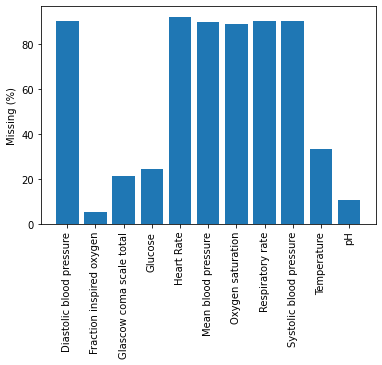

In [ ]:
# As simple statistics, calculate missing values percentages
missing_percent = ((N * T) - (1-missing.reshape(-1, D)).sum(0)) / (N * T) * 100
missing_percent

# Plotting
plt.bar(list(dict_variables.values()), missing_percent)
plt.xticks(list(dict_variables.values()), list(dict_variables.keys()), rotation=90)
plt.ylabel('Missing (%)')
plt.show()

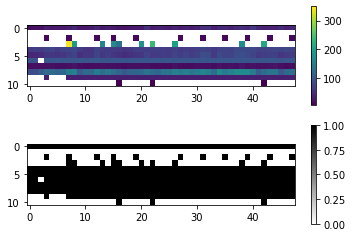

In [ ]:
# Visualize 1 sample
fig, ax = plt.subplots(2, 1)
im1 = ax[0].imshow(cohorts[0].T)
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].imshow(missing[0].T, cmap='binary')
fig.colorbar(im2, ax=ax[1])
plt.show()

In [ ]:
# Normalization
def normalize(data, mask, mu=None, std=None):
    N, T, D = data.shape
    X = data.copy().reshape(-1, D)
    M = mask.copy().reshape(-1, D)

    isnew = 0
    if mu is None or std is None:
        isnew = 1
        mean_set = np.zeros([D])
        std_set = np.zeros([D])
    else:
        mean_set = mu
        std_set = std

    for d in range(D):
        idx = np.where(M[:,d] == 1)[0]
        if idx.sum()==0:
            continue
        if isnew:
            X_mu = np.mean(X[:, d][idx])
            X_std = np.std(X[:, d][idx])
            # Store the Mean & STD Set
            mean_set[d] = X_mu
            std_set[d] = X_std
        else:
            X_mu = mu[d]
            X_std = std[d]

        # Loop for each idx
        for ix in idx:
            if X_std != 0:
                X[:, d][ix] = (X[:, d][ix] - X_mu) / X_std
            else:
                X[:, d][ix] = X[:, d][ix] - X_mu

    X_norm = X.reshape(N, T, D)
    return X_norm, mean_set, std_set

# Data
X_train = cohorts[train_ids]
X_valid = cohorts[valid_ids]
X_test = cohorts[test_ids]

# Missing indicator
missing_train = missing[train_ids]
missing_valid = missing[valid_ids]
missing_test = missing[test_ids]

# Normalization
X_train_norm, mu, std = normalize(X_train, missing_train)
X_valid_norm, _, _ = normalize(X_valid, missing_valid, mu, std)
X_test_norm, _, _ = normalize(X_test, missing_test, mu, std)

In [ ]:
# Show mean and std for each variables
mu, std

(array([ 60.71957801,   0.54368783,  11.57088628, 142.1547202 ,
         86.95118098,  79.11648785,  97.41893782,  19.06270279,
        120.64892453,  37.03858367,   7.37457366]),
 array([48.38231356,  0.20010132,  3.9562053 , 59.78631066, 18.37962372,
        15.15703431, 57.14903335,  5.70773059, 21.74620414,  0.99296924,
         0.07652638]))

In [ ]:
# Missing values imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# Constant (Zero) Imputation
imp_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
imp_zero.fit(X_train_norm.reshape(-1, D))
X_train_zero = imp_zero.transform(X_train_norm.reshape(-1, D)).reshape(N_train, T, D)
X_valid_zero = imp_zero.transform(X_valid_norm.reshape(-1, D)).reshape(N_valid, T, D)
X_test_zero = imp_zero.transform(X_test_norm.reshape(-1, D)).reshape(N_test, T, D)

# Mean Imputation
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train_norm.reshape(-1, D))
X_train_mean = imp_mean.transform(X_train_norm.reshape(-1, D)).reshape(N_train, T, D)
X_valid_mean = imp_mean.transform(X_valid_norm.reshape(-1, D)).reshape(N_valid, T, D)
X_test_mean = imp_mean.transform(X_test_norm.reshape(-1, D)).reshape(N_test, T, D)

# Median Imputation
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(X_train_norm.reshape(-1, D))
X_train_median = imp_median.transform(X_train_norm.reshape(-1, D)).reshape(N_train, T, D)
X_valid_median = imp_median.transform(X_valid_norm.reshape(-1, D)).reshape(N_valid, T, D)
X_test_median = imp_median.transform(X_test_norm.reshape(-1, D)).reshape(N_test, T, D)

# Iterative Imputation
imp_iter = IterativeImputer(max_iter=10, random_state=0)
imp_iter.fit(X_train_norm.reshape(-1, D))
X_train_iter = imp_iter.transform(X_train_norm.reshape(-1, D)).reshape(N_train, T, D)
X_valid_iter = imp_iter.transform(X_valid_norm.reshape(-1, D)).reshape(N_valid, T, D)
X_test_iter = imp_iter.transform(X_test_norm.reshape(-1, D)).reshape(N_test, T, D)

# KNN Imputer 
# Took quite some time ~3m
imp_knn = KNNImputer(n_neighbors=2, weights="uniform")
imp_knn.fit(X_train_norm.reshape(-1, D))
X_train_knn = imp_knn.transform(X_train_norm.reshape(-1, D)).reshape(N_train, T, D)
X_valid_knn = imp_knn.transform(X_valid_norm.reshape(-1, D)).reshape(N_valid, T, D)
X_test_knn = imp_knn.transform(X_test_norm.reshape(-1, D)).reshape(N_test, T, D)


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


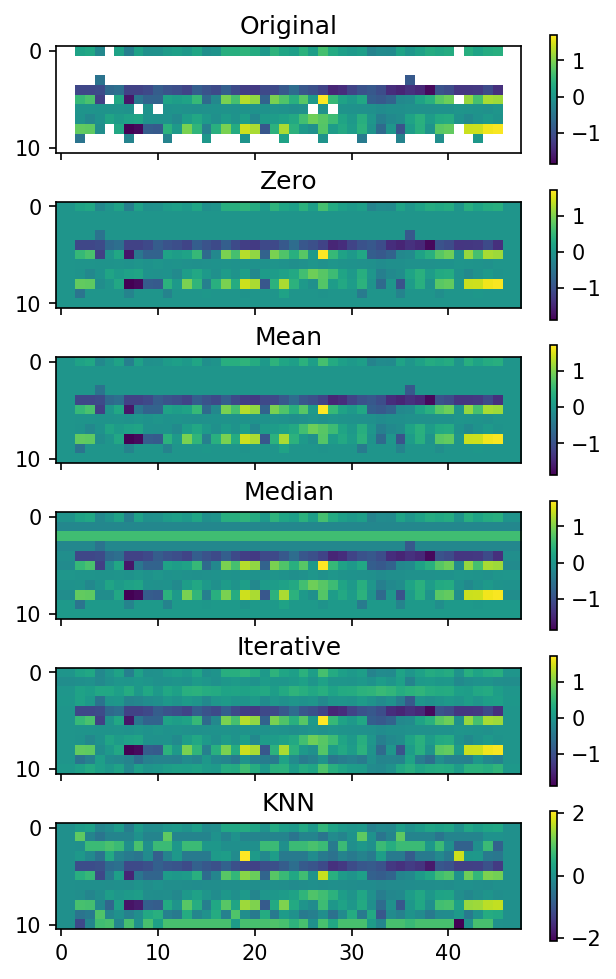

In [ ]:
# Visualize the imputed values for 1 sample
fig, ax = plt.subplots(6, 1, sharex=True, figsize=(5,8), dpi= 150)
im1 = ax[0].imshow(X_train_norm[1].T)
ax[0].set_title('Original')
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].imshow(X_train_zero[1].T)
ax[1].set_title('Zero')
fig.colorbar(im2, ax=ax[1])

im3 = ax[2].imshow(X_train_mean[1].T)
ax[2].set_title('Mean')
fig.colorbar(im3, ax=ax[2])

im4 = ax[3].imshow(X_train_median[1].T)
ax[3].set_title('Median')
fig.colorbar(im4, ax=ax[3])

im5 = ax[4].imshow(X_train_iter[1].T)
ax[4].set_title('Iterative')
fig.colorbar(im5, ax=ax[4])

im6 = ax[5].imshow(X_train_knn[1].T)
ax[5].set_title('KNN')
fig.colorbar(im6, ax=ax[5])

plt.show()

# Prediction Task

In [ ]:
import torch.nn as nn
import torch as torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import math as math 
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define data loader
def make_data_loader(X, y, batch_size=32, shuffle=True):
  # Make pair between data and its corresponding label
  records = [{'data': torch.from_numpy(x),
              'label': torch.from_numpy(y[i])} for i, x in enumerate(X)]

  # Define data loader
  loader = DataLoader(records,
                      batch_size=batch_size,
                      num_workers=1,
                      shuffle=shuffle,
                      pin_memory=True)

  return loader

device

device(type='cuda', index=0)

In [ ]:
# Make dataloader
batch_size = 32
dataloader = {}
for imp in ['zero', 'mean', 'median', 'iter', 'knn']:
  # Make a tuple consisted of train, validation and test set
  d = {}
  d['train'] = make_data_loader(eval('X_train_%s' % imp), y_train, batch_size)
  d['valid'] = make_data_loader(eval('X_valid_%s' % imp), y_valid, batch_size, shuffle=False)
  d['test'] = make_data_loader(eval('X_test_%s' % imp), y_test, batch_size, shuffle=False)
  # Store in the dictionary
  dataloader[imp] = d

In [ ]:
# Define RNN Model
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_classes):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.gru = nn.GRU(input_dim, 
                          hidden_dim, 
                          n_layers, 
                          batch_first=True)
        self.fc = nn.Sequential(
             nn.Linear(hidden_dim, hidden_dim * 2),
             nn.Tanh(),
             nn.Linear(hidden_dim * 2, n_classes),
             nn.Sigmoid()
        )
        
        self.reset_parameters();

    def reset_parameters(self):
        for weight in self.parameters():
            if len(weight.size()) == 1:
                continue
            stv = 1. / math.sqrt(weight.size(1))
            nn.init.uniform_(weight, -stv, stv)        

    def forward(self, x):
        # Call GRU
        h = self.gru(x)
        
        # Call FC given the hidden states
        y = self.fc(h[0].contiguous()[:, -1, :])

        return y

In [ ]:
# Model Configuration
input_dim = D
hidden_dim = 32
n_layers = 1
n_classes = 1

rnn = RNN(input_dim, hidden_dim, n_layers, n_classes).to(device)

# Define the loss and optimizer
lr = 0.00001
l2 = 0.0001
epochs = 500
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr, weight_decay=l2)

In [ ]:
from sklearn.metrics import accuracy_score

def get_score(y, y_hat):
  return accuracy_score(y.flatten(), (y_hat.flatten() > 0.5) * 1)

In [ ]:
# Train the model
def train(epoch, dataloader):
  loss_ = 0
  n_samples = 0
  y_ = np.empty([0, 1])
  y_hat_ = np.empty([0, 1])
  for i, xbatch in enumerate(dataloader):

      # Zero grad
      optimizer.zero_grad()

      # Retrieve data from batches
      X = xbatch['data'].float().to(device)
      y = xbatch['label'].float().to(device)
      
      # Forward pass
      y_hat = rnn(X)
      loss = criterion(y_hat, y)
      
      # Backward pass
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_ += loss.item()
      n_samples += X.shape[0]

      # Records true label and its prediction
      # print(y.to('cpu').detach().numpy().T.shape)
      y_ = np.vstack([y_, y.to('cpu').detach().numpy()])
      y_hat_ = np.vstack([y_hat_, y_hat.to('cpu').detach().numpy()])

  # print('Epoch %s Training loss %.5f' % (epoch, loss_ / n_samples))

  acc_ = get_score(y_, y_hat_)

  return loss_ / n_samples, acc_

# Validate the model
def evaluate(phase, epoch, dataloader):
  loss_ = 0
  n_samples = 0
  y_ = np.empty([0, 1])
  y_hat_ = np.empty([0, 1])
  for i, xbatch in enumerate(dataloader):

      # Retrieve data from batches
      X = xbatch['data'].float().to(device)
      y = xbatch['label'].float().to(device)
      
      # Forward pass
      y_hat = rnn(X)
      loss = criterion(y_hat, y)
      
      loss_ += loss.item()
      n_samples += X.shape[0]

      # Records true label and its prediction
      y_ = np.vstack([y_, y.to('cpu').detach().numpy()])
      y_hat_ = np.vstack([y_hat_, y_hat.to('cpu').detach().numpy()])

  # print('Epoch %d %s loss %.5f' % (epoch, phase, loss_ / n_samples))
  acc_ = get_score(y_, y_hat_)

  return loss_ / n_samples, acc_


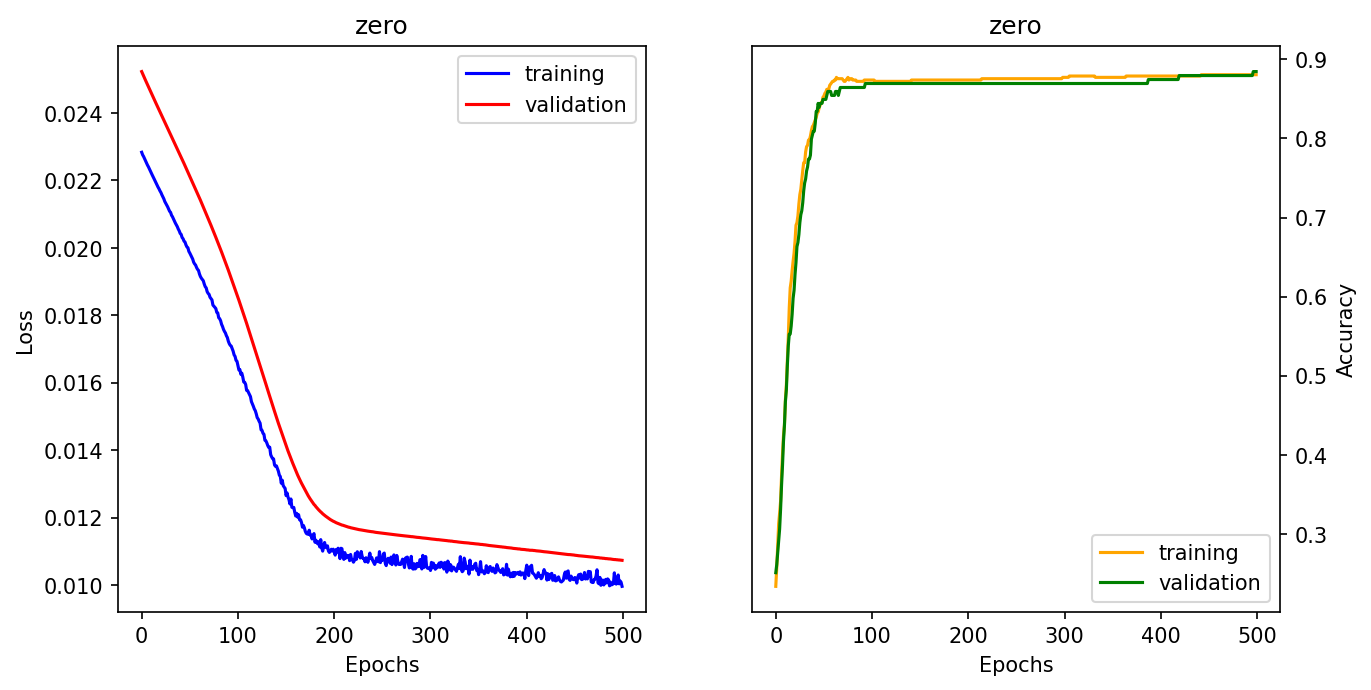

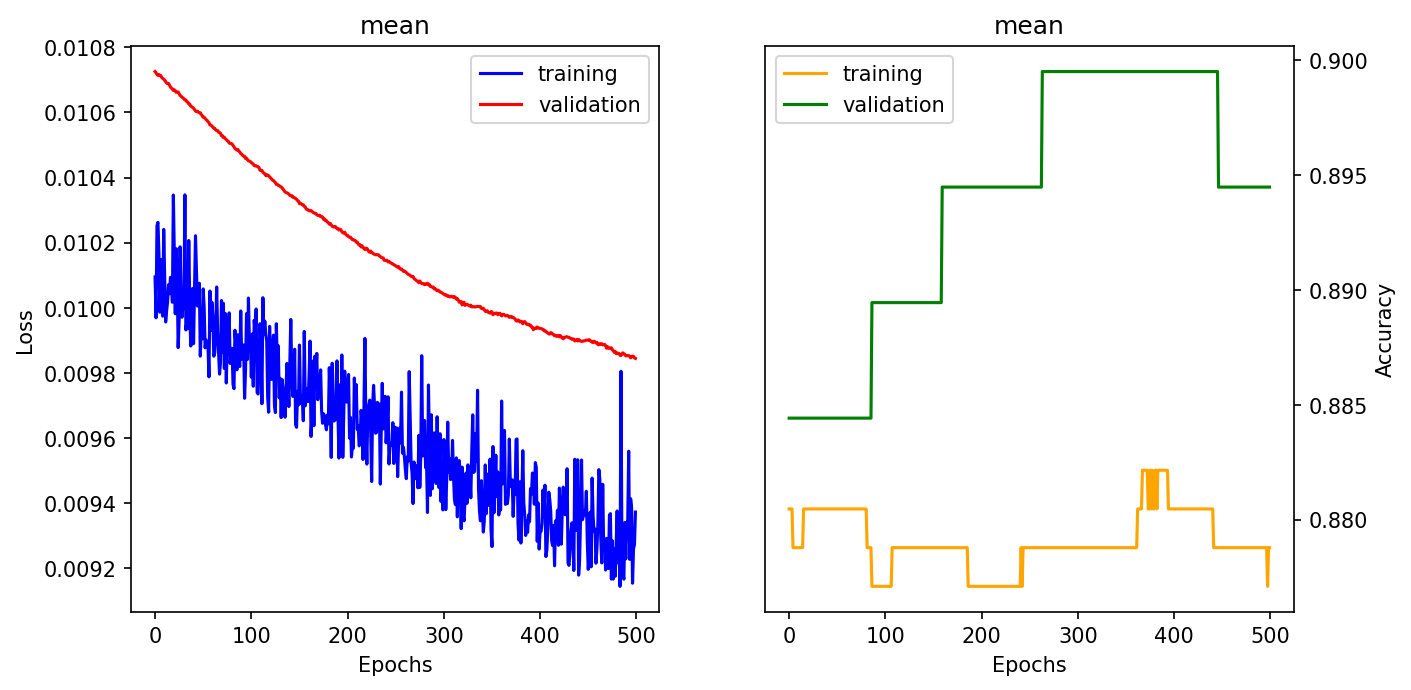

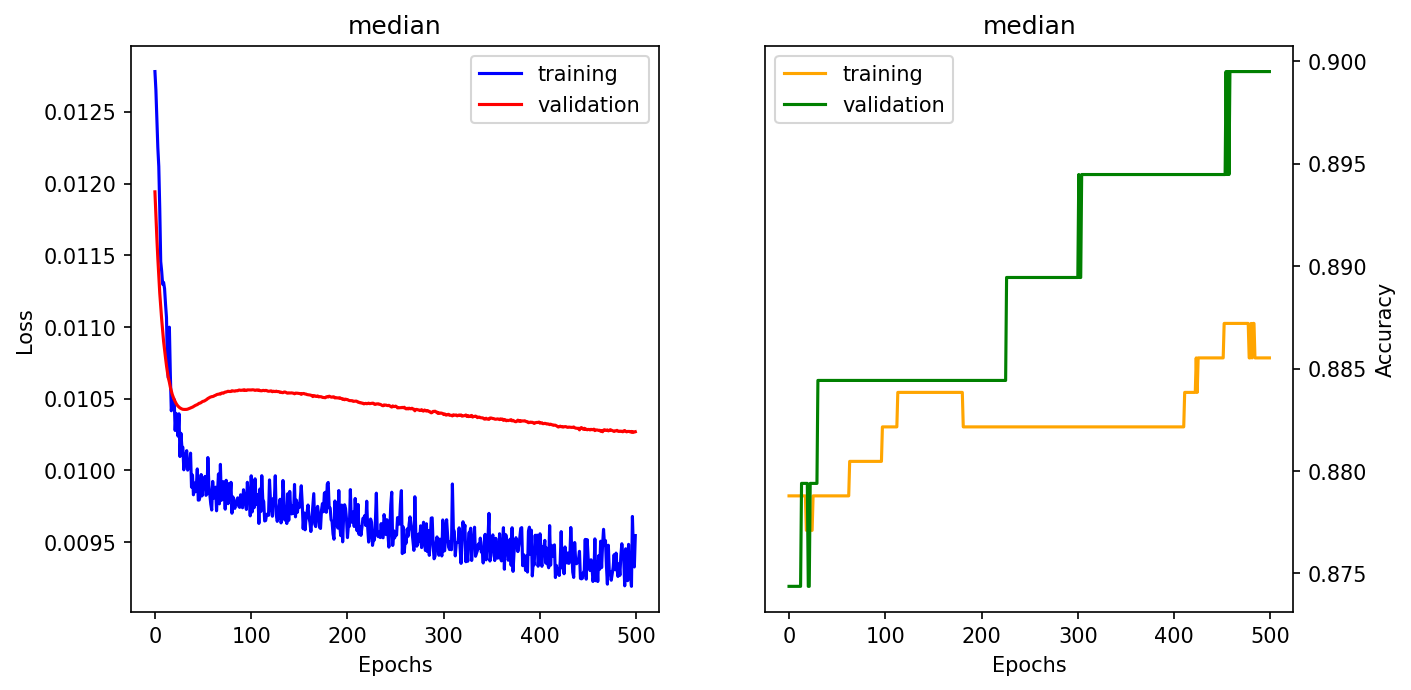

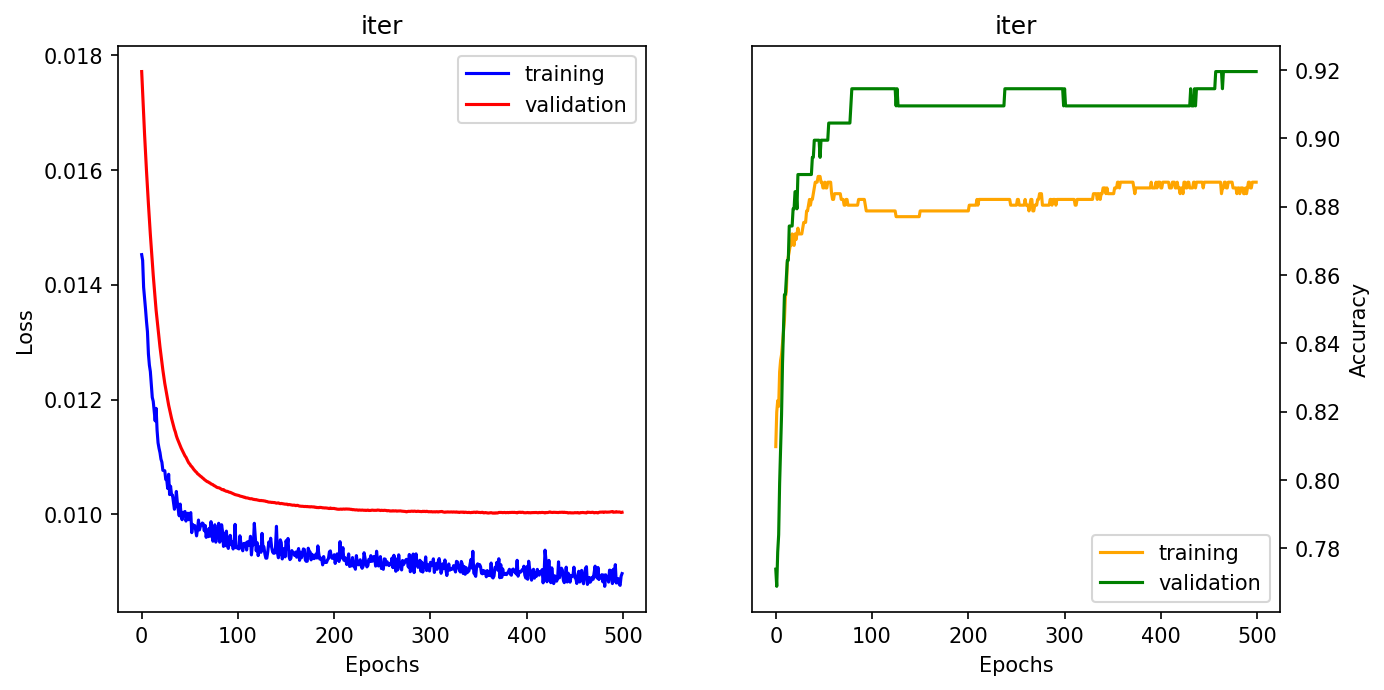

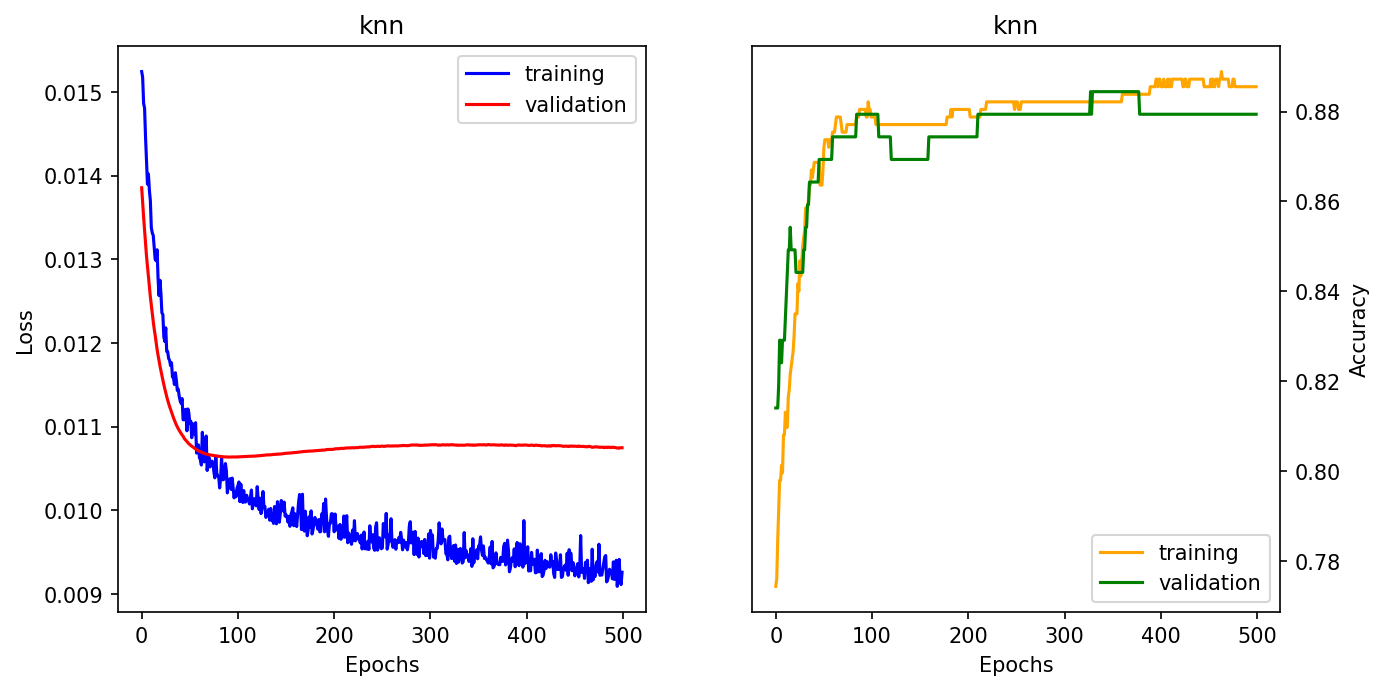

In [ ]:
# Loop for each epochs
for imp in ['zero', 'mean', 'median', 'iter', 'knn']:
  losses = np.empty([0, 2])
  accs = np.empty([0, 2])
  for epoch in range(epochs):
    
    # Training
    loss_train, acc_train = train(epoch, dataloader[imp]['train'])

    # Validation
    loss_valid, acc_valid = evaluate('Validation', epoch, dataloader[imp]['valid'])

    losses = np.vstack([losses, [loss_train, loss_valid]])
    accs = np.vstack([accs, [acc_train, acc_valid]])

  # Show curve
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=150)
  ax[0].plot(np.arange(losses.shape[0]), losses[:, 0], color='blue', label='training')
  ax[0].plot(np.arange(losses.shape[0]), losses[:, 1], color='red', label='validation')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].set_title(imp)
  ax[0].legend()

  ax[1].plot(np.arange(accs.shape[0]), accs[:, 0], color='orange', label='training')
  ax[1].plot(np.arange(accs.shape[0]), accs[:, 1], color='green', label='validation')
  ax[1].yaxis.tick_right()
  ax[1].yaxis.set_label_position("right")
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_title(imp)
  ax[1].legend()

  plt.show()
  plt.close()

